In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from Models import GRU, RNN, MLP, GRU_V2, GRU_V3
from sklearn.metrics import mean_absolute_error
from RecDataLoader import Dataset
import pickle

In [2]:
BSC = pd.read_csv('./original_data/Base_station_basic_info.csv')
CLD = pd.read_csv('./original_data/Cell-level_data.csv')
ECD = pd.read_csv('./original_data/Energy_consumption_data.csv')
PCD = pd.read_csv('./original_data/Power_consumption_prediction.csv') #26139


merged_df = CLD.merge(BSC, on=['BS', 'CellName'], how='inner')
fullmerged_df = merged_df.merge(ECD, on=['BS', 'Time'], how='left') # merge + wyjscie

unique_cells_per_base = fullmerged_df.groupby('BS')['CellName'].nunique()
one_cell_bases = unique_cells_per_base[unique_cells_per_base == 1].index
two_cell_bases = unique_cells_per_base[unique_cells_per_base == 2].index
four_cell_bases = unique_cells_per_base[unique_cells_per_base == 4].index

# print(one_cell_bases)
# print(two_cell_bases)
# print(four_cell_bases)

# print(fullmerged_df["BS"].value_counts())
# print(PCD["BS"].value_counts())

bs_set1 = set(fullmerged_df['BS'])
bs_set2 = set(PCD['BS'])

missing_variables = bs_set1.difference(bs_set2) #okazuje się ze B_924 i B_946 nie ma w PCD
print(missing_variables)
eval_data_1cell = PCD[PCD['BS'].isin(one_cell_bases)]

{'B_946', 'B_924'}


In [3]:
eval_time_stamps = eval_data_1cell[['Time', 'BS']]

seq_len = 3
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# data = Dataset(data_path="./prepared_data/One_Cell_merged_all.csv", eval_time_stamps=eval_time_stamps,  seq_len=seq_len, eval_percentage=0.05)
data = Dataset(data_path="./prepared_data/One_Cell_merged_with_preds.csv", eval_time_stamps=eval_time_stamps,  seq_len=seq_len, eval_percentage=0.05)
data_x, data_y = data.get_data()

val_data_x, val_data_y = data.get_validation_data()

trainset = torch.utils.data.TensorDataset(torch.from_numpy(data_x).float(), torch.from_numpy(data_y).float())
testset = torch.utils.data.TensorDataset(torch.from_numpy(val_data_x).float(), torch.from_numpy(val_data_y).float())


dataset = torch.utils.data.TensorDataset(torch.from_numpy(data_x).float(), torch.from_numpy(data_y).float())

# seed = 111
# torch.manual_seed(seed)
# trainset, testset = torch.utils.data.random_split(dataset, [int(len(dataset)*0.9), len(dataset) - int(len(dataset)*0.9)])
print(len(trainset), len(testset))

trainloader = torch.utils.data.DataLoader(trainset, batch_size=512, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=512, shuffle=True)

Rec data prep progress: 100%|██████████| 92285/92285 [02:30<00:00, 613.46it/s]


67628 probek 1h do przodu, 3081 probek 2h do przodu, 0 probek 3h do przodu,0 probek 4h do przodu,0 probek 5h do przodu, 20749 probek >5h do przodu
Udalo sie wypelnic 20787/20787 probek eval
88795 3490


In [5]:
input_size = trainloader.dataset.tensors[0].shape[2]
output_size = trainloader.dataset.tensors[1].shape[1]
model = GRU_V2(input_size, 512, 2, 1).to(device)
print(f'Input = {input_size}, Output = {output_size}')
model.load_state_dict(torch.load("./trained_models/GRU_1cell_N4_seq_len_3.tar"))

Input = 27, Output = 1


<All keys matched successfully>

In [6]:
def mae_eval(model):
    model.eval()
    all_preds = []
    all_outs = []
    # val_mean_abs_errors = []
    for i, (x, y) in enumerate(testloader):
        x = x.view(-1, seq_len, input_size).requires_grad_().to(device)
        # x = x.view(-1, seq_len*input_size).requires_grad_().to(device)
        hidden = model.init_hidden(x).to(device)
        x, y = x.to(device), y.to(device)
        # print(x.shape, y.shape)
        # preds = model(x) 
        preds = model(x, hidden) 
        preds = preds.reshape(x.size(0), -1)
        y = y.reshape(x.size(0), -1)
        all_preds.append(preds.detach().cpu().numpy())
        all_outs.append(y.detach().cpu().numpy())
    all_preds = np.concatenate(all_preds, axis=0)
    all_outs = np.concatenate(all_outs, axis=0)
    mae = mean_absolute_error(all_preds, all_outs)
    return mae

In [7]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
# model.load_state_dict(torch.load("./trained_models/with_preds/GRU_1cell_N5_seq_len_3.tar"))

In [8]:
model.train()

all_loss = []
val_mean_abs_error = []
avg_loss = 0
epochs_without_progress = 0
min_mae = mae_eval(model)

print(f'Initial val MAE: {min_mae:.4f}')

num_epochs = 0

for epoch in range(num_epochs):
    for i, (x, y) in enumerate(trainloader):
        model.train()
        x = x.view(-1, seq_len, input_size).requires_grad_().to(device)
        optimizer.zero_grad()
        hidden = model.init_hidden(x).to(device)
        x, y = x.to(device), y.to(device)
        preds = model(x, hidden) 
        preds = preds.reshape(x.size(0), -1)
        y = y.reshape(x.size(0), -1)
        loss = criterion(preds, y)
        loss.backward()
        avg_loss += loss.item()
        optimizer.step()
    mae = mae_eval(model)
    val_mean_abs_error.append(mae)
    if mae < min_mae:
        min_mae = mae
        print(f'New min MAE: {min_mae:.4f}')
        # torch.save(model.state_dict(), f"./trained_models/with_preds/GRU_1cell_seq_len_{seq_len}_min.tar")
        epochs_without_progress = 0
    else:
        epochs_without_progress += 1
        if epochs_without_progress > 20:
            print("Early stopping")
            epochs_without_progress = 0
            model.load_state_dict(torch.load(f"./trained_models/with_preds/MLP_1cell_seq_len_{seq_len}_min.tar"))

    # print(f'Epoch: {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, val MAE: {mae:.4f}')
    all_loss.append(avg_loss)
    avg_loss = 0
print(f'Best val MAE: {min_mae:.4f}')

Initial val MAE: 1.1255
Best val MAE: 1.1255


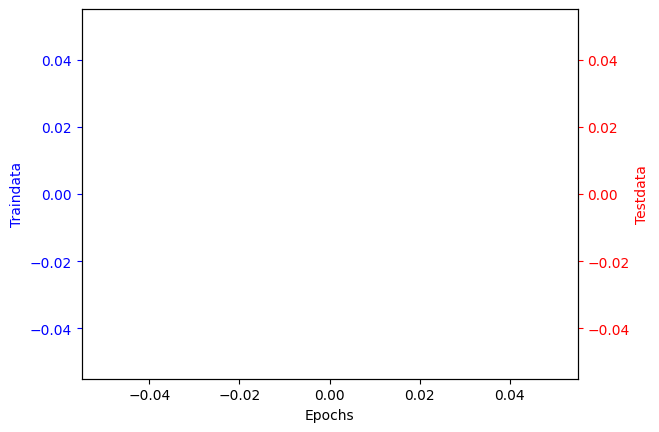

In [9]:
fig, ax1 = plt.subplots()
ax1.plot(all_loss, 'b-')
ax1.set_xlabel('Epochs', color='k')
ax1.set_ylabel('Traindata', color='b')
ax1.tick_params('y', colors='b')

# smoothed_L1Loss = savgol_filter(all_L1Loss, window_length=12, polyorder=3)
ax2 = ax1.twinx()
ax2.plot(val_mean_abs_error, 'r')
ax2.set_ylabel('Testdata', color='r')
ax2.tick_params('y', colors='r')
plt.show()

In [10]:
eval_data, eval_datastamps = data.get_eval_data()

eval_dataset = torch.utils.data.TensorDataset(torch.from_numpy(eval_data).float())

eval_loader = torch.utils.data.DataLoader(eval_dataset, shuffle=False)

In [11]:
# model.load_state_dict(torch.load(f"./trained_models/with_preds/GRU_1cell_seq_len_{seq_len}_min.tar"))
# torch.save(model.state_dict(), f"./trained_models/with_preds/GRU_1cell_N2_seq_len_{seq_len}_preds.tar")
mae = mae_eval(model)
print(f'Best val MAE: {mae:.4f}')

model.eval()
cell1_preds = []
with torch.no_grad():
    for i, x in enumerate(eval_loader):
        x = x[0].to(device)
        hidden = model.init_hidden(x).to(device)
        preds = model(x, hidden)
        preds = preds.to(device).cpu().numpy()
        cell1_preds.append(preds)

cell1_preds = np.concatenate(cell1_preds, axis=0)
cell1_preds_dict = {}
for key, value in zip(eval_datastamps, cell1_preds):
    key_tuple = tuple(key)
    cell1_preds_dict[key_tuple] = value


with open('./pickle/cell1_preds_dict.pkl', 'wb') as file:
    pickle.dump(cell1_preds_dict, file)

Best val MAE: 1.1255
